In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
color = sns.color_palette()

%matplotlib inline

In [3]:
train_df = pd.read_csv("mertrain.csv")
test_df = pd.read_csv("mertest.csv")

In [4]:
for c in train_df.columns:
    if train_df[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train_df[c].values) + list(test_df[c].values))
        train_df[c] = lbl.transform(list(train_df[c].values))
        test_df[c] = lbl.transform(list(test_df[c].values))

In [12]:
n_comp = 10

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train_df.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test_df)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train_df.drop(["y"], axis=1))
pca2_results_test = pca.transform(test_df)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train_df.drop(["y"], axis=1))
ica2_results_test = ica.transform(test_df)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train_df.drop(["y"], axis=1))
grp_results_test = grp.transform(test_df)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train_df.drop(["y"], axis=1))
srp_results_test = srp.transform(test_df)

In [13]:
usable_columns = list(set(train_df.columns) - set(['y']))

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    train_df['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test_df['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train_df['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test_df['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train_df['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test_df['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train_df['grp_' + str(i)] = grp_results_train[:, i - 1]
    test_df['grp_' + str(i)] = grp_results_test[:, i - 1]

    train_df['srp_' + str(i)] = srp_results_train[:, i - 1]
    test_df['srp_' + str(i)] = srp_results_test[:, i - 1]

In [14]:
y_train = train['y'].values
y_mean = np.mean(y_train)
id_test = test['ID'].values
finaltrainset = train[usable_columns].values
finaltestset = test[usable_columns].values


In [15]:
import xgboost as xgb

# prepare dict of params for xgboost to run with
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(finaltrainset, y_train)
dtest = xgb.DMatrix(finaltestset)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.6398	test-rmse:12.6384
[50]	train-rmse:11.0841	test-rmse:11.1481
[100]	train-rmse:10.0012	test-rmse:10.1349
[150]	train-rmse:9.26144	test-rmse:9.46608
[200]	train-rmse:8.76257	test-rmse:9.03683
[250]	train-rmse:8.42587	test-rmse:8.76965
[300]	train-rmse:8.19398	test-rmse:8.60527
[350]	train-rmse:8.02599	test-rmse:8.50735
[400]	train-rmse:7.87548	test-rmse:8.45376
[450]	train-rmse:7.73273	test-rmse:8.4241
500


In [16]:
from sklearn.metrics import r2_score

# now fixed, correct calculation
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.618086154678


In [17]:
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test_df['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('xgboost-depth{}-feature.csv'.format(xgb_params['max_depth']), index=False)


In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

In [30]:
select = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold
                        ="median")

In [26]:
y_train.shape

(4209,)

In [31]:
select.fit(finaltrainset, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold='median')

In [32]:
X_train_l1=select.transform(finaltrainset)

In [33]:
X_test_l1=select.transform(finaltestset)

In [34]:
dtrain_l1 = xgb.DMatrix(X_train_l1, y_train)
dtest_l1 = xgb.DMatrix(X_test_l1)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain_l1, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.6398	test-rmse:12.6384
[50]	train-rmse:11.0841	test-rmse:11.1481
[100]	train-rmse:10.0012	test-rmse:10.1349
[150]	train-rmse:9.26144	test-rmse:9.46608
[200]	train-rmse:8.76257	test-rmse:9.03683
[250]	train-rmse:8.42587	test-rmse:8.76965
[300]	train-rmse:8.19398	test-rmse:8.60527
[350]	train-rmse:8.02599	test-rmse:8.50735
[400]	train-rmse:7.87548	test-rmse:8.45376
[450]	train-rmse:7.73273	test-rmse:8.4241
500


In [35]:
print(r2_score(dtrain_l1.get_label(), model.predict(dtrain_l1)))

0.618567120345


In [37]:
y_pred_l1 = model.predict(dtest_l1)
output = pd.DataFrame({'id': test_df['ID'].astype(np.int32), 'y': y_pred_l1})
output.to_csv('xgboost-depth{}-imp.csv'.format(xgb_params['max_depth']), index=False)


In [38]:
mask=select.get_support()

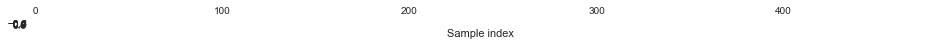

In [39]:
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel("Sample index")

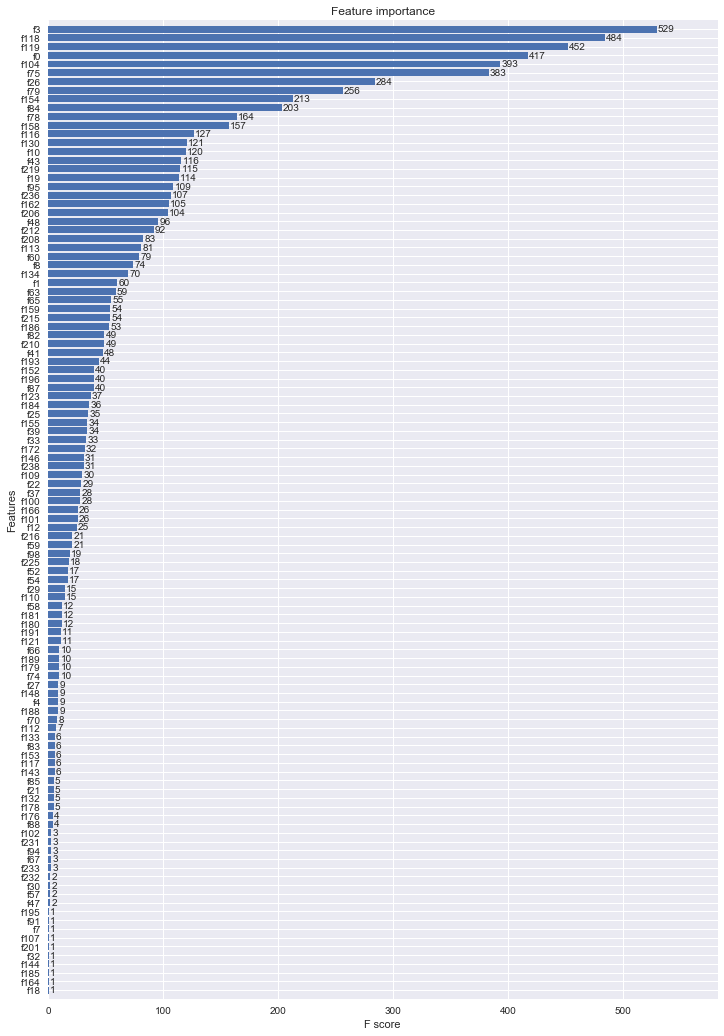

In [41]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()